In [1]:
from PIL import Image
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
lpms = ["10lpm","16lpm","25lpm"]
pwds = ["rechts_links","rechts_links_45"]

"""

    Bildernamen: pos_sagital/meridonial_lpms.png

"""
path = "imgs/ausschnitt"


img_dict = {}

horizontal = []
vertikal   = []
sagital    = []
meridonial = []

pattern = regex = r"([\d])_{}_([\d])\.png"

def getFiles(pwd,pattern):
    files = []
    x = 0
    y = 0
    for file in os.listdir(pwd):
        matches = re.search(pattern, file)
        if matches:
            y_tmp = int(matches[2])
            x_tmp = int(matches[1])
            if x_tmp > x:
                x = x_tmp
            if y_tmp > y:
                y = y_tmp
            files.append((matches[0],(x_tmp,y_tmp )))
            
    for i,pair in enumerate(files):
        files[i] = (pair[0],pair[1][0]+1 + ((pair[1][1] % (y+1) )*(y+1)))
    files = sorted(files, key=lambda position: position[1])
    return files,(x+1,y+1)


def to_matrix(files,size):
    mat = []
    x,y = size
    new_row = []
    for item in files:
        index = item[1]
        i,j = (index // y,index % y)
        new_row.append(item[0])
        if j == y - 1:
            mat.append(new_row)
            new_row = []
        
    return np.array(mat)

img_dict = { "h" : None,
             "v" : None,
             "s" : None,
             "m" : None
            }

for key in img_dict:
    files,size = getFiles(path,pattern.format(key))
    img_dict[key] = to_matrix(files,size)


$$Kontrast = \frac{Max - Min}{Max + Min}$$

In [3]:




def middleSquare(img,margin_x = 40,margin_y = 40,edge=False):
    
    """
        
        Ein Quadrat in der Mitte ausschneiden
    
    """
    
    x,y = img.shape[:2]
    
    x = x // 2
    y = y // 2
    
    if not edge:
        return img[x-margin_x:x+margin_x,y-margin_y: y+ margin_y]
    else:
        return None
    

    
def openImages(pwd,files):
    
    """
    
        Namen der Bilder liegen in einer Liste vor,
        die Bilder öffnen und wieder in einer Liste zurückgeben
    
    """
    
    img_array = [middleSquare(np.array(Image.open(os.path.join(pwd,file))))
                    [:,:,0] for file in files]
    return img_array
    
def concatenate_images(img_mat):
    
    """
    
    
    """
    
    
    x,y = img_mat.shape[:2]
    
    concat = None
    #fig, axes = plt.subplots(x, 1, figsize=(10, 10), sharex=True, sharey=True)
    for row in img_mat:
        concatenate = None
        for image in row:
            img = np.array(Image.open(os.path.join(path,image)))[:,:,0]
            img = middleSquare(img)
            #img[np.where(img >= 150.0)] = 0
             

            if concatenate is None:
                concatenate = img
                continue
            concatenate = np.concatenate((concatenate,img),axis = 1)
        if concat is None:
            concat = concatenate
        else:
            concat = np.concatenate((concat,concatenate),axis=0)
        
    concat = np.array(concat)
    #plt.imshow(concat,cmap="gray")
    """
    for i,img in enumerate(concat):
        axes[i].imshow(img,cmap="gray")
    """
    
    return np.array(concat)
            

def calcModulationMatrix(root,imgs):
    img_mat = []
    for key in imgs:
        img_mat.append(openImages(root,key))
    
    img_mat = np.array(img_mat,dtype=np.float32)
    img_mat_max = img_mat.copy()

    def calcModulation(min_i,max_i):
        return ( max_i.max() - min_i.min() ) /  (max_i.max() + min_i.min())

    
    modulation_matrix = []
    std_matrix = []
    
    x,y = img_mat_max.shape[:2]
    
    for i in range(x):
        row = [ calcModulation(img_mat[i,j],img_mat_max[i,j]) for j in range(y)]
        row_std = [ img_mat[i,j].std() for j in range(y)]
        modulation_matrix.append(row)
        std_matrix.append(row_std)
        
    modulation_matrix = np.array(modulation_matrix,dtype=np.float32)
    std_matrix = np.array(std_matrix,dtype=np.float32)
    x,y = modulation_matrix.shape
    ret = np.zeros((x,y,2))
    ret[:,:,0] = modulation_matrix
    ret[:,:,1] = std_matrix
    return ret


modulation = {}
for key in img_dict:
    modulation[key] = calcModulationMatrix(path,img_dict[key])
    

In [4]:
def plotMTF(modulationMatrix,
            imageMatrix,
            xlabels,
            legende,
            ylabel="MTF [%]",
            transpose=False):
    
    if transpose:
        modulationMatrix = modulationMatrix.T
        imageMatrix = imageMatrix.T
        x_label = "Lp/mm"

    
    else:
        tmp = legende
        legende = xlabels
        xlabels = tmp
        x_label = "Position"
        
        

        
        
    fig, axes = plt.subplots(1, 2, figsize=(20, 5),dpi=100, sharex=False, sharey=False)
    #figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
    for i,row in enumerate(modulationMatrix):
        axes[0].plot(xlabels[:len(row)],row*100,label=legende[i])
        axes[0].legend(loc='upper right')
        axes[0].set_xlabel(x_label)
        axes[0].set_ylabel(ylabel)
        axes[0].grid(linestyle='-', linewidth=0.5)
        
    
    axes[1].imshow(imageMatrix,cmap="gray")
    axes[1].grid(color="red",linewidth=2)
    
    
    stepsize_y = imageMatrix.shape[1] / modulationMatrix.shape[1]
    stepsize_x = imageMatrix.shape[0] /modulationMatrix.shape[0]
    
    if transpose:
        endpoint_x = stepsize_x
        endpoint_y = 0
    else:
        endpoint_y = stepsize_y
        endpoint_x = 0

    y_ticks = np.arange(0, imageMatrix.shape[1] + 2*endpoint_y, stepsize_y)
    x_ticks = np.arange(0, imageMatrix.shape[0] + 2*endpoint_x, stepsize_x)
    axes[1].set_xticks(x_ticks)
    axes[1].set_yticks(y_ticks)

    plt.show()





In [5]:
def plotAuswertung(modulationMatrix,
                   stdMatrix,
                   imageMatrix,
                   xlabels,
                   legende,
                   ylabel="MTF [%]",
                   transpose=False):
    
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20),dpi=100, sharex=False, sharey=False)
    
    x_label_T = "Lp/mm"
    x_label_mod = "Position"
    
    if transpose:
        modulationMatrix = modulationMatrix.T
        stdMatrix = stdMatrix.T
        imageMatrix = imageMatrix.T
        tmp = legende
        legende = xlabels
        xlabels = tmp
        
        tmp = x_label_T
        x_label_T = x_label_mod
        x_label_mod = tmp
        
        
    
    stepsize_y = imageMatrix.shape[1] // modulationMatrix.shape[1]
    stepsize_x = imageMatrix.shape[0] // modulationMatrix.shape[0]
    
    if transpose:
        endpoint_x = stepsize_x
        endpoint_y = 0
    else:
        endpoint_y = stepsize_y
        endpoint_x = 0    
    
    for i,row in enumerate(modulationMatrix):
        axes[0,0].plot(xlabels[:len(row)],row*100,label=legende[i])
        axes[0,0].legend(loc='upper right')
        axes[0,0].set_xlabel(x_label_mod)
        axes[0,0].set_ylabel(ylabel)
        axes[0,0].grid(linestyle='-', linewidth=0.5)


    for i,row in enumerate(modulationMatrix.T):
        axes[0,1].plot(legende[:len(row)],row*100,label=xlabels[i])
        axes[0,1].legend(loc='upper right')
        axes[0,1].set_xlabel(x_label_T)
        axes[0,1].set_ylabel(ylabel)
        axes[0,1].grid(linestyle='-', linewidth=0.5)
    
    
    for i,row in enumerate(stdMatrix):
        axes[1,0].plot(xlabels[:len(row)],row*100,label=legende[i])
        axes[1,0].legend(loc='upper right')
        axes[1,0].set_xlabel(x_label_mod)
        axes[1,0].set_ylabel("STD")
        axes[1,0].grid(linestyle='-', linewidth=0.5)
        
    
    axes[1,1].imshow(imageMatrix,cmap="gray")
    axes[1,1].grid(color="red",linewidth=2)
    


    y_ticks = np.arange(0, imageMatrix.shape[1] + 2*endpoint_y, stepsize_y)
    x_ticks = np.arange(0, imageMatrix.shape[0] + 2*endpoint_x, stepsize_x)

    axes[1,1].set_xticks(x_ticks)
    axes[1,1].set_yticks(y_ticks)

    plt.show()



In [6]:
transpose = True
legende = ["10","16","25","32","50","100"]
xlabels = ["mitte","m+1","m+2","m+3","rand"]

[Meridonial](imgs/vertikal.jpg)

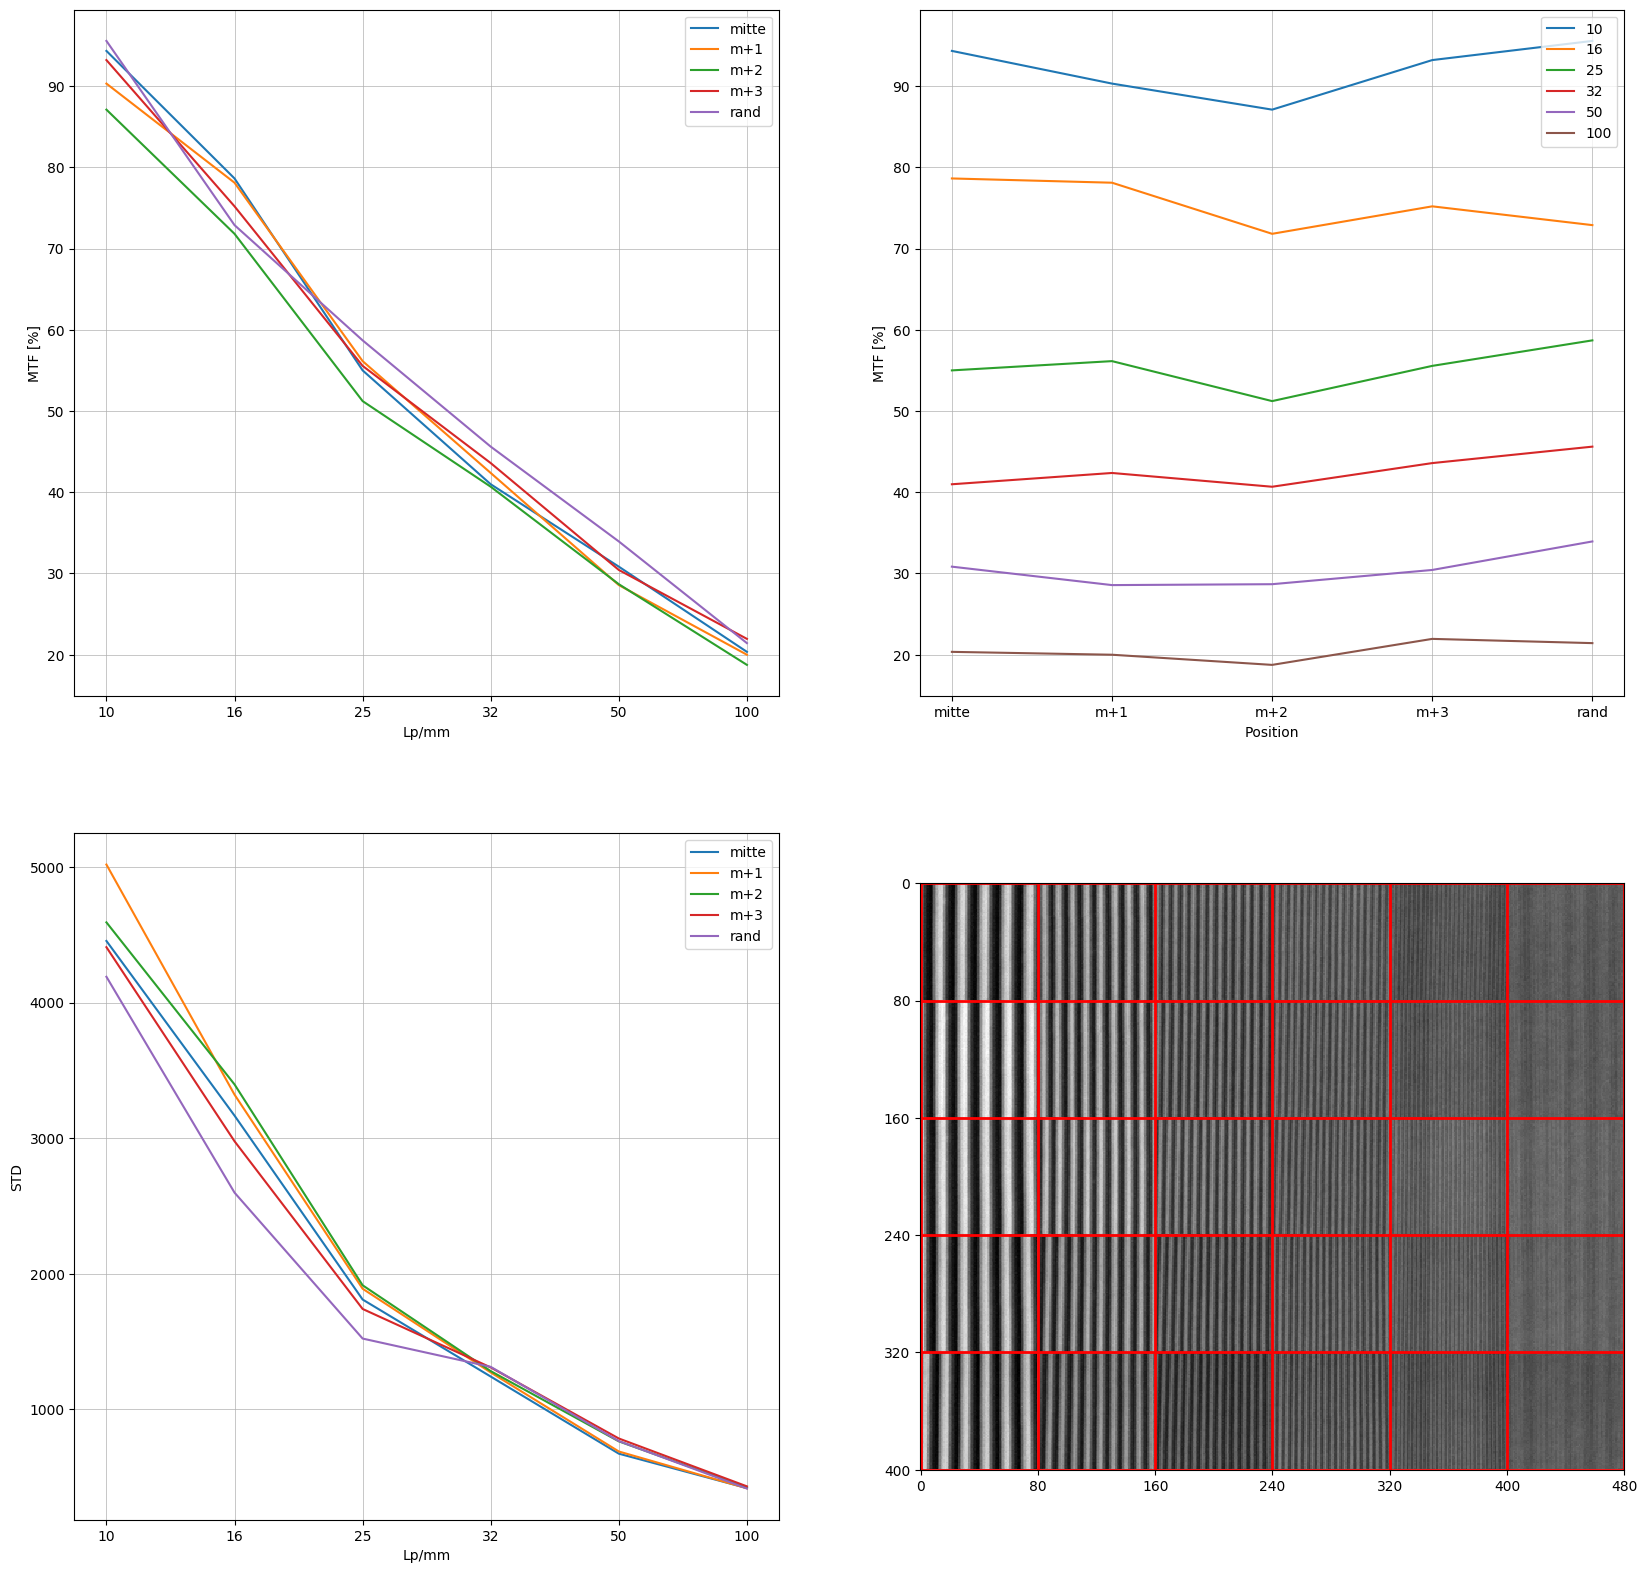

In [11]:
plotAuswertung(modulation['h'][:,:,0],
               modulation['h'][:,:,1],
               concatenate_images(img_dict['h']),
               xlabels=xlabels,
               legende= legende,
               transpose=transpose)
    


### Position:

   * Änderung der Position hat keine extreme Auswirkung auf die MTF. Zusehen an den Charts in Position 
    [0,0] und [1,0].
    
   * Man sieht dennoch, dass die Darstellung der Linien in Richtung Zentrum besser ist, als in Richtung rand.
    
### Lp/mm:

   * Die Lp/mm eine größere Auswirkung, je mehr Linien pro mm, desto schlechter die Darstellung

---

[Sagital](imgs/horizontal.jpg)

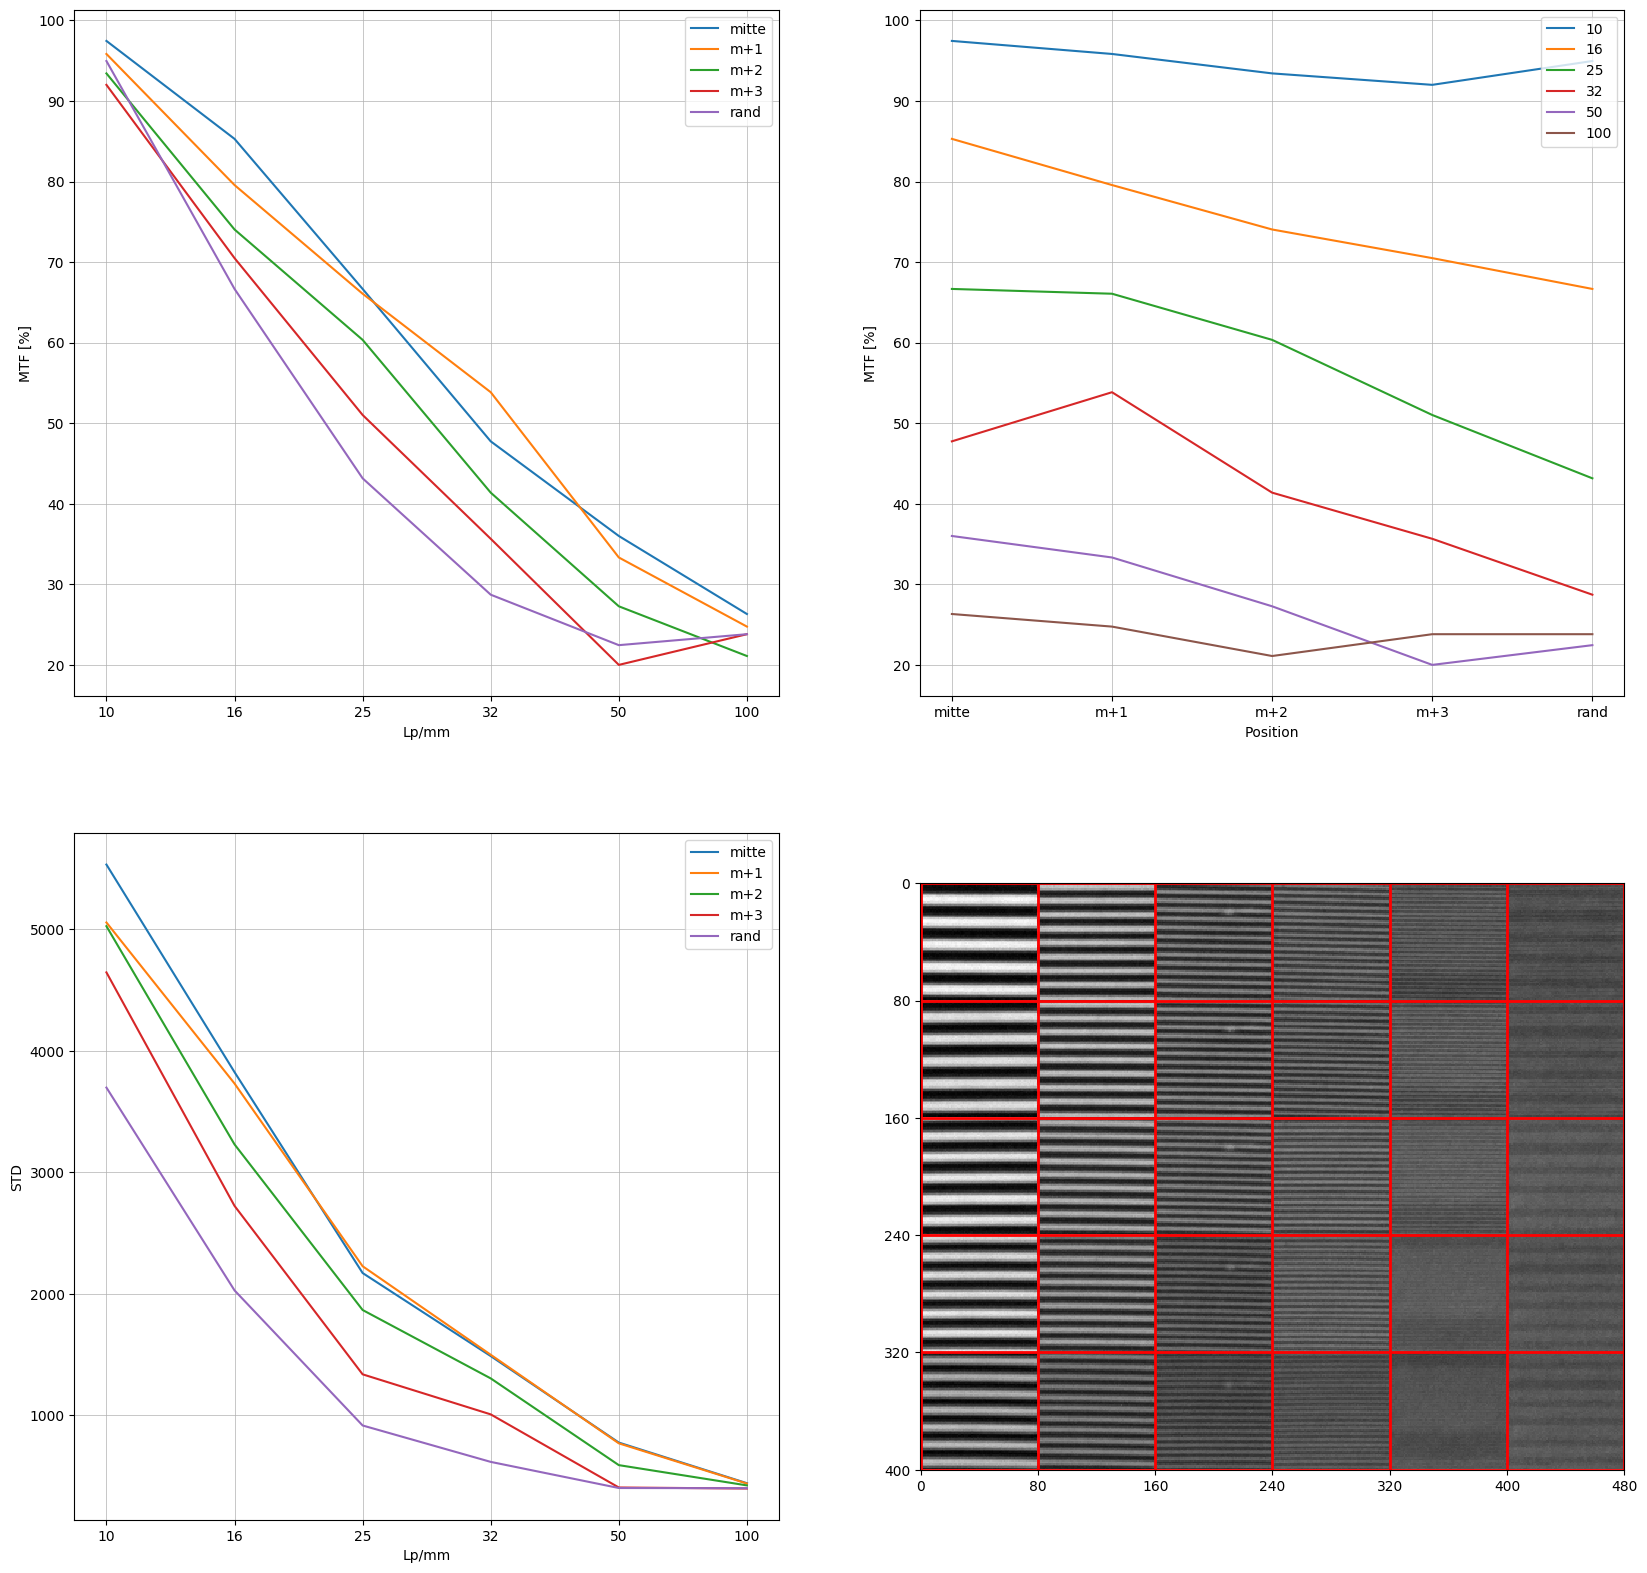

In [12]:
plotAuswertung(modulation['v'][:,:,0],
               modulation['v'][:,:,1],
               concatenate_images(img_dict['v']),
               xlabels=xlabels,
               legende= legende,
               transpose=transpose)

[Sagital](imgs/sagital.jpg)

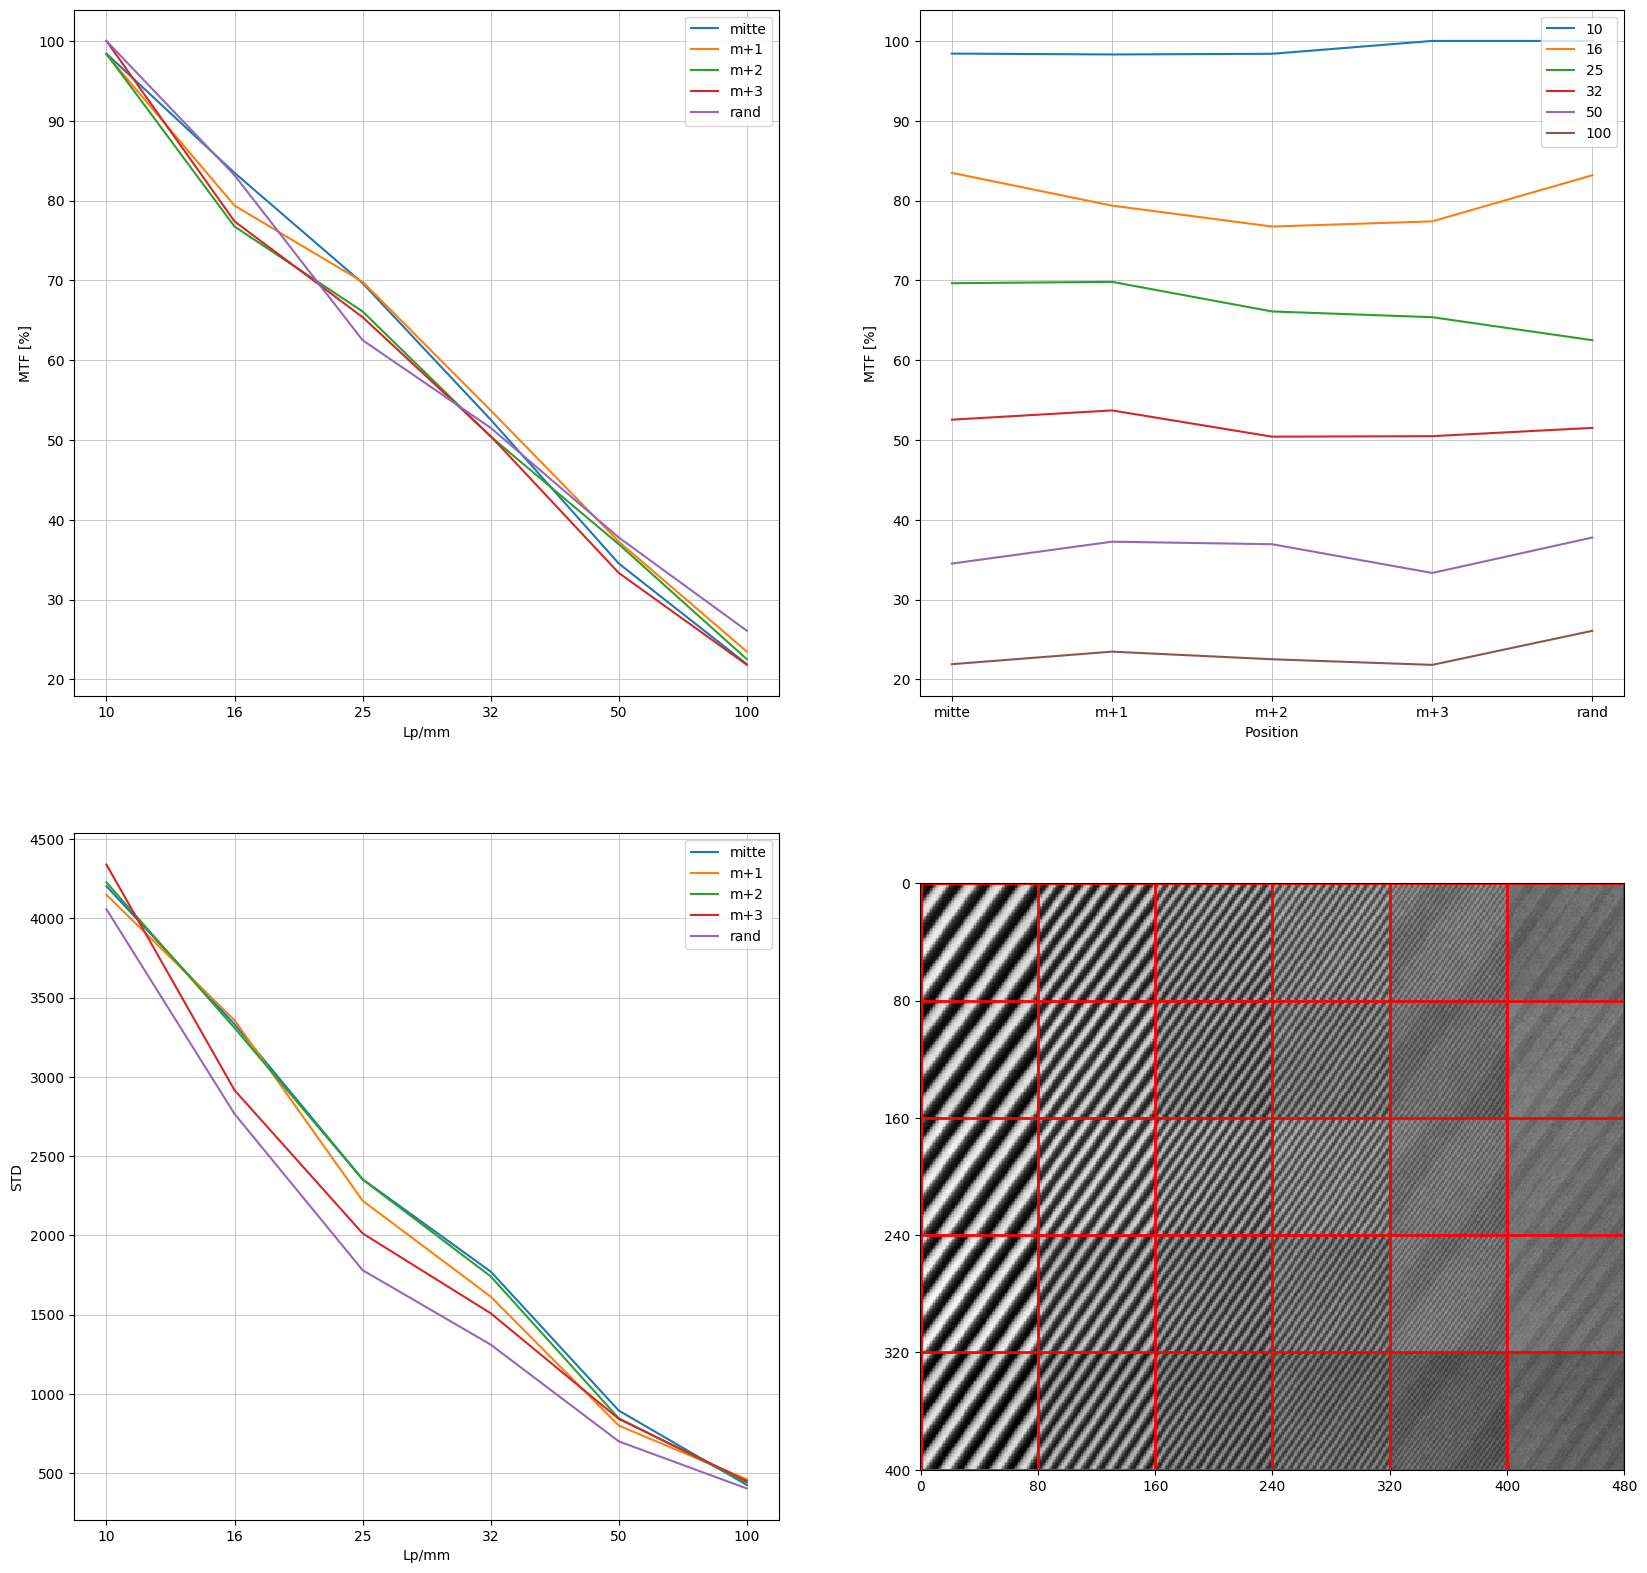

In [13]:
plotAuswertung(modulation['s'][:,:,0],
               modulation['s'][:,:,1],
               concatenate_images(img_dict['s']),
               xlabels=xlabels,
               legende= legende,
               transpose=transpose)

[Meridonial](imgs/meridal.jpg)

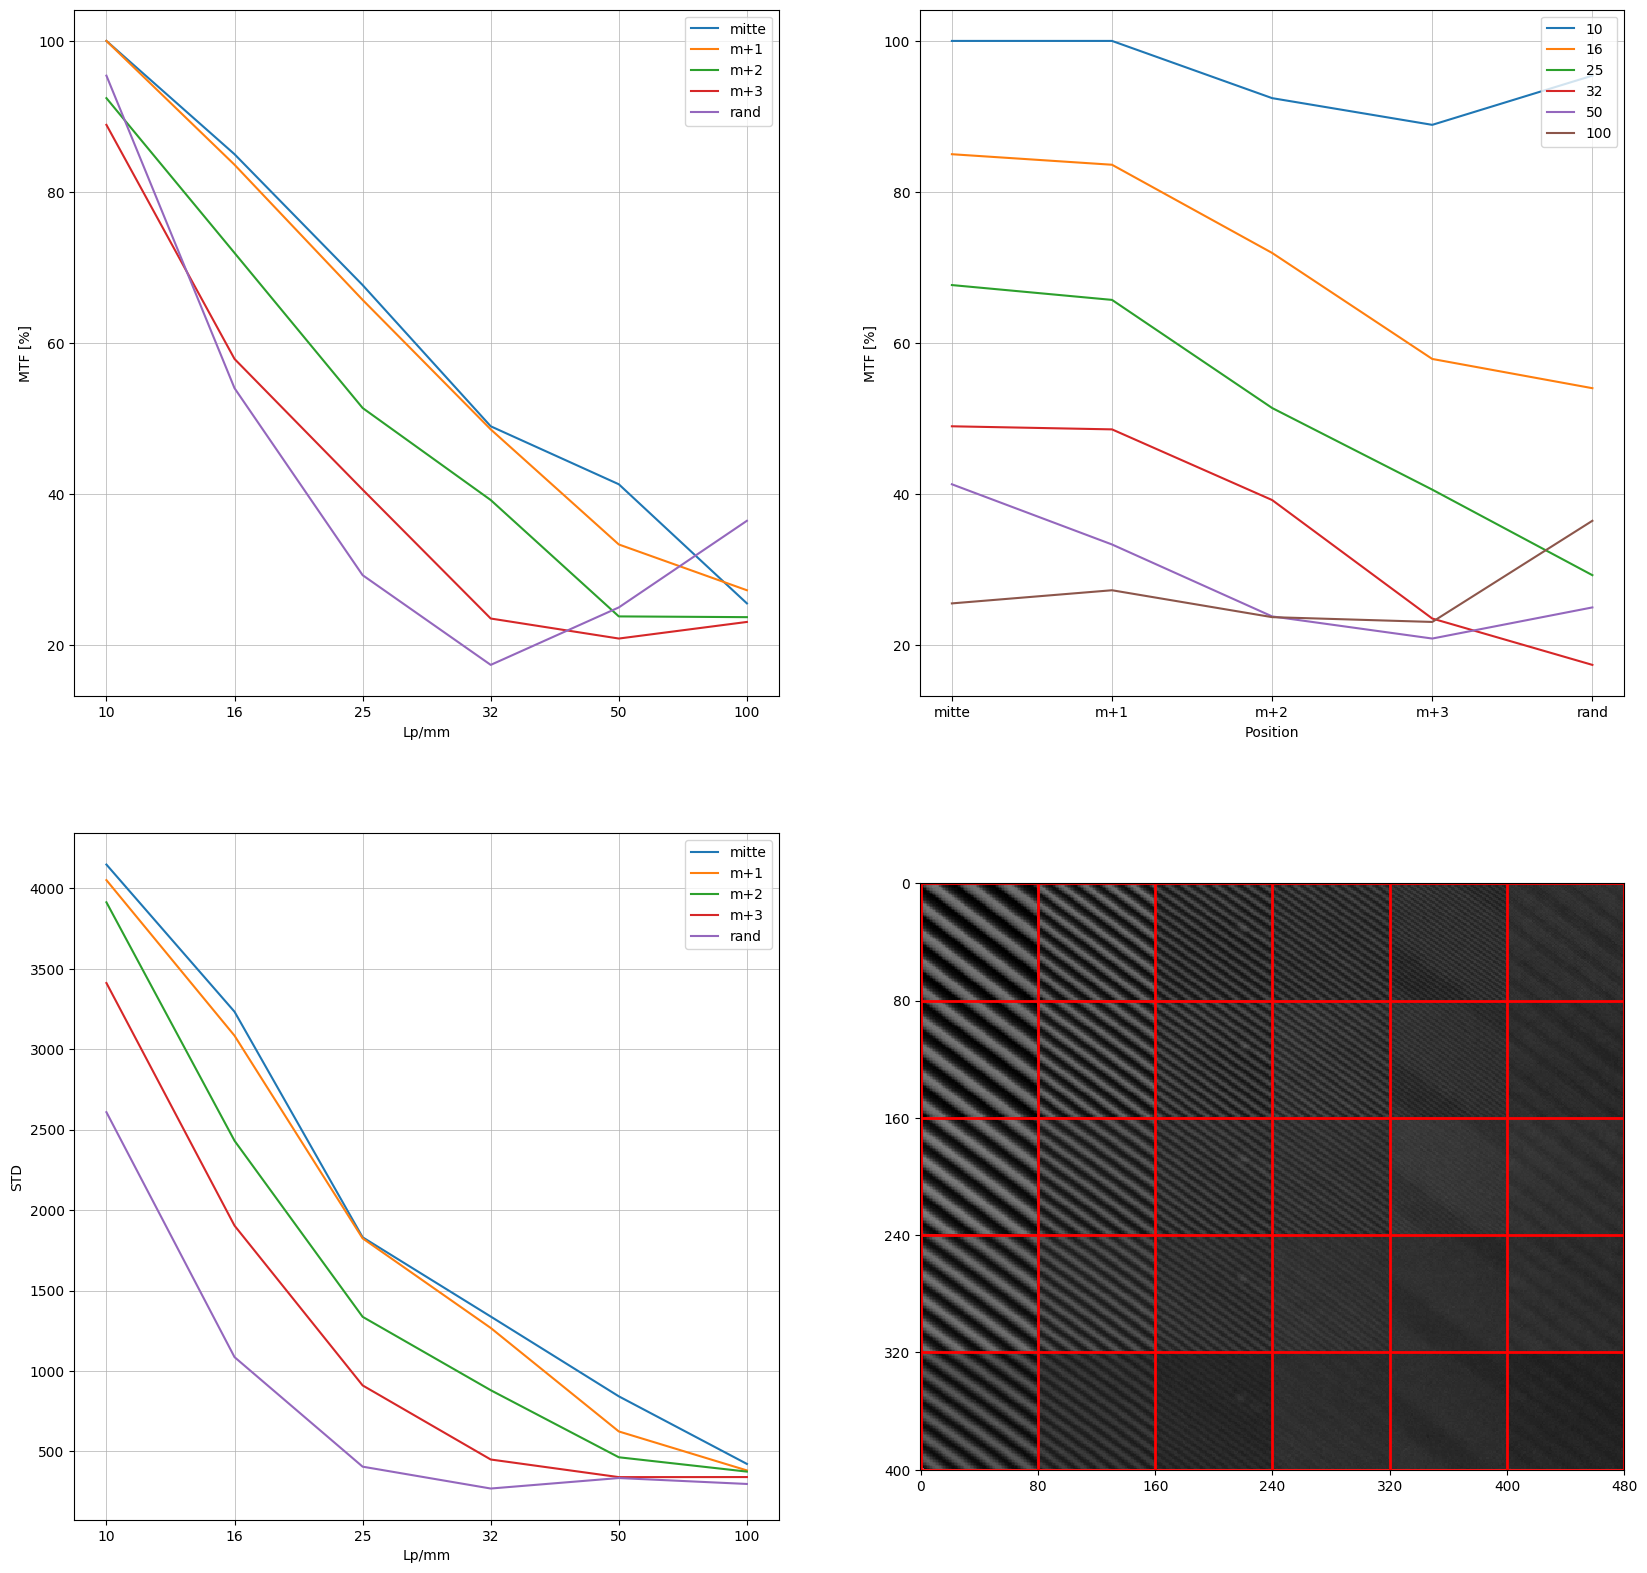

In [14]:
plotAuswertung(modulation['m'][:,:,0],
               modulation['m'][:,:,1],
               concatenate_images(img_dict['m']),
               xlabels=xlabels,
               legende= legende,
               transpose=transpose)